In [3]:
from operator import sub
from numpy.core.numeric import roll
import pandas as pd
import numpy as np
from arch import arch_model
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
from glob import glob
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy import stats
from scipy.special import erf
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from scipy.stats import multivariate_normal,kstest,norm,t
from scipy.interpolate import interp1d
from scipy.stats import kurtosis, skew
from scipy.special import erf
from joblib import Parallel, delayed
from scipy.optimize import minimize
from statsmodels.distributions.empirical_distribution import ECDF
from pandas.tseries.offsets import Day, BDay
from datetime import date
import matplotlib.ticker as mtick
import os
import h5py
from joblib import wrap_non_picklable_objects
from hmmlearn import hmm
# Load our own helper and plottingfunctions
#from plottingfunctions import *
#from helperfunctions import *
# Set number of cores if we do something parallel
Ncores=6
# Set stylesheet for nice plotting
plt.style.use('../QRM1/OOP/stylesheet')

In [ ]:
df = pd.read_excel('./dataset_group18-1.xlsx')
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
treasury = pd.read_csv('treasury30.csv').set_index('DATE').replace('.',np.nan).astype(float)
treasury.index = pd.to_datetime(treasury.index)
df = pd.merge(df,treasury,left_index=True,right_index=True)
bondprice = np.exp(-30*df['DGS30']/100)*100
df['bondreturn'] = np.log(bondprice)-np.log(bondprice.shift(1))

In [148]:
df = df.dropna()

In [149]:
bond_value = np.exp(-30*df['Treasury_Yield_30Y'])

In [150]:
df['Bondportfolio'] = np.exp(-1*df['Treasury_Yield_30Y'])-1

In [151]:
df['CrudeOil_EUR'] = df['CrudeOil_USD'] + df['EUR_USD_Curr_YahF_USD']
df['SP500_Idx_YahF_EUR'] = df['SP500_Idx_YahF_USD'] + df['EUR_USD_Curr_YahF_USD']
df['Nikkei_225_Idx_YahF_EUR'] = df['Nikkei_225_Idx_YahF_JPY'] + df['EUR_JPY_Curr_YahF_JPY']
df['SSE_Composite_Idx_YahF_EUR'] = df['SSE_Composite_Idx_YahF_CNY'] + df['EUR_CNY_Curr_YahF_CNY']

In [152]:
stocks = ['CrudeOil_EUR',
          'EuroNext_100_Idx_YahF_EUR',
          'SP500_Idx_YahF_EUR',
          'SSE_Composite_Idx_YahF_EUR',
          'Nikkei_225_Idx_YahF_EUR',
          'bondreturn']
weights = np.array([0.15, 0.2, 0.15, 0.2, 0.15, 0.15])

In [153]:
portfolio_returns = np.dot(weights, df[stocks].T)

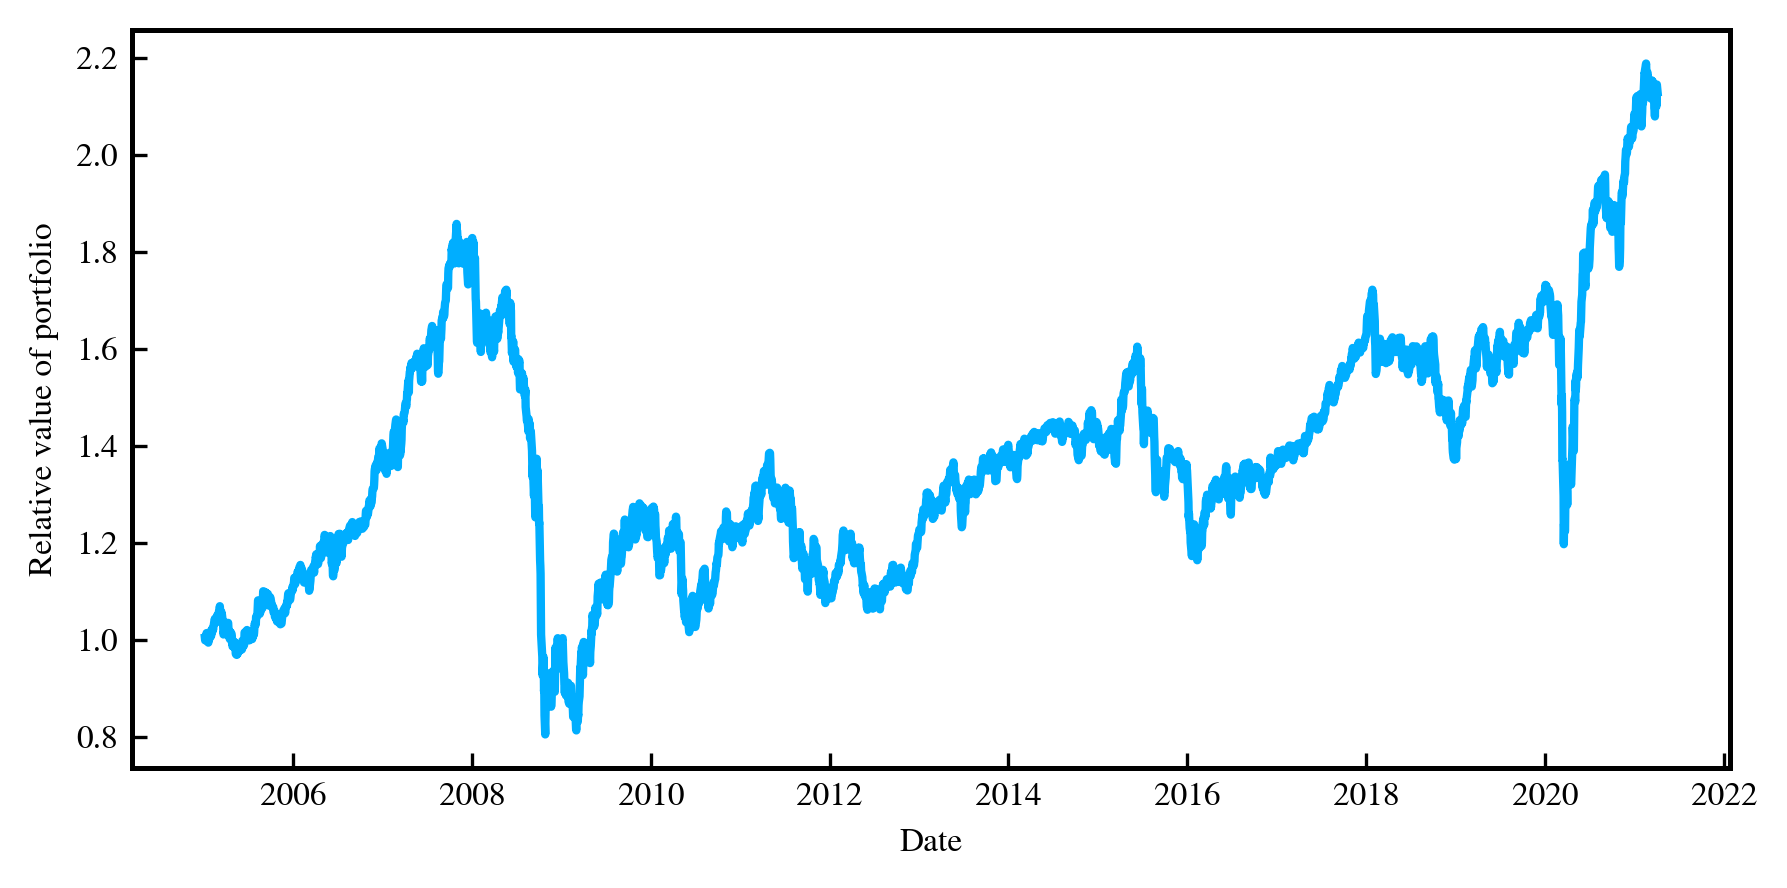

In [226]:
plt.figure(figsize=(6,3))
plt.plot(df.index, np.exp(np.cumsum(portfolio_returns)))
plt.xlabel('Date')
plt.ylabel('Relative value of portfolio')
plt.tight_layout()
plt.savefig('prices_index.pdf')


In [240]:
# CCC method with GARCH(1,1)
def corr_to_cov(corr_matrix, stdevs):
    """
    Convert a correlation matrix to a covariance matrix

    :param corr_matrix: correlation matrix
    :type corr_matrix: pd.DataFrame
    :param stdevs: vector of standard deviations
    :type stdevs: array-like
    :return: covariance matrix
    :rtype: pd.DataFrame
    """
    if not isinstance(corr_matrix, pd.DataFrame):
        warnings.warn("corr_matrix is not a dataframe", RuntimeWarning)
        corr_matrix = pd.DataFrame(corr_matrix)

    return corr_matrix * np.outer(stdevs, stdevs)


def __portfolio_variance__(weights, covmat):
    """Get portfolio variance given weights and covariance matrix"""
    return np.dot(np.dot(weights.T, covmat), weights)

def CCC(df, stocks, weights, estimation_period=5*252):
    predictions = pd.DataFrame({'VaR01' :np.zeros(len(df))*np.nan,
                                'VaR025':np.zeros(len(df))*np.nan,
                                'ES01'  :np.zeros(len(df))*np.nan,
                                'Date'  :df.index}).set_index('Date')

    # Estimate constant correlation matrix using GARCH
    subreturns = df
    # Do we want to exclude stressed periods?
    residuals    = pd.DataFrame(index=subreturns.index)
    volatilities = pd.DataFrame(index=subreturns.index)
    fitted_models = {}
    for i,asset in enumerate(stocks):
        ret = subreturns[asset].dropna()
        dates = ret.index
        ret = ret.values.flatten()
        # Scaling to improve GARCH estimation
        C = 3
        ret = ret * 10**C
        # Fit constant mean GARCH(1,1) model
        am = arch_model(ret, p=1,q=1)
        res = am.fit(update_freq=0,)
        # Get conditional volatilities
        volas = res.conditional_volatility
        # Estimate empirical distribution of zt
        zt = (ret-ret.mean()) / volas
        residuals.loc[dates,asset] = zt
        volatilities.loc[dates,asset] = volas
        fitted_models[asset] = res

    # Estimate fixed correlation matrix
    cons_corrmat = residuals.corr()
    # Use volatilities from GARCH to estimate VaRs
    for date,returns in df.iloc[:-1].iterrows():
        # predict volatility one day ahead
        omegas = np.array([fitted_models[w].params['omega'] for w in stocks])
        alphas = np.array([fitted_models[w].params['alpha[1]'] for w in stocks])
        betas = np.array([fitted_models[w].params['beta[1]'] for w in stocks])
        pred_vola = np.sqrt(omegas+alphas*(returns* 10**C)**2+betas*volatilities.loc[date]**2) / (10**C)
        CCC_covmat = corr_to_cov(cons_corrmat, pred_vola.values)
        portfolio_variance = __portfolio_variance__(weights, CCC_covmat)

        VaR01  = np.sqrt(portfolio_variance) * norm.ppf(1-0.01) - np.dot(weights, df.mean())
        VaR025 = np.sqrt(portfolio_variance) * norm.ppf(1-0.025) - np.dot(weights, df.mean())
        ES01   = np.sqrt(portfolio_variance) * 1/0.01 * norm.pdf(norm.ppf(0.01)) - np.dot(weights, df.mean())
        # Prediction data
        pred_date = df.loc[date:].index[1]
        predictions.loc[pred_date] = [VaR01,VaR025,ES01]
    return predictions

In [241]:
ccc = CCC(df[stocks], stocks, weights)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 18139.114481333272
            Iterations: 10
            Function evaluations: 58
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15070.966046870222
            Iterations: 10
            Function evaluations: 59
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15391.946921472185
            Iterations: 11
            Function evaluations: 66
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16856.669407681846
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 16712.86044475431
            Iterations: 8
            Function evalu

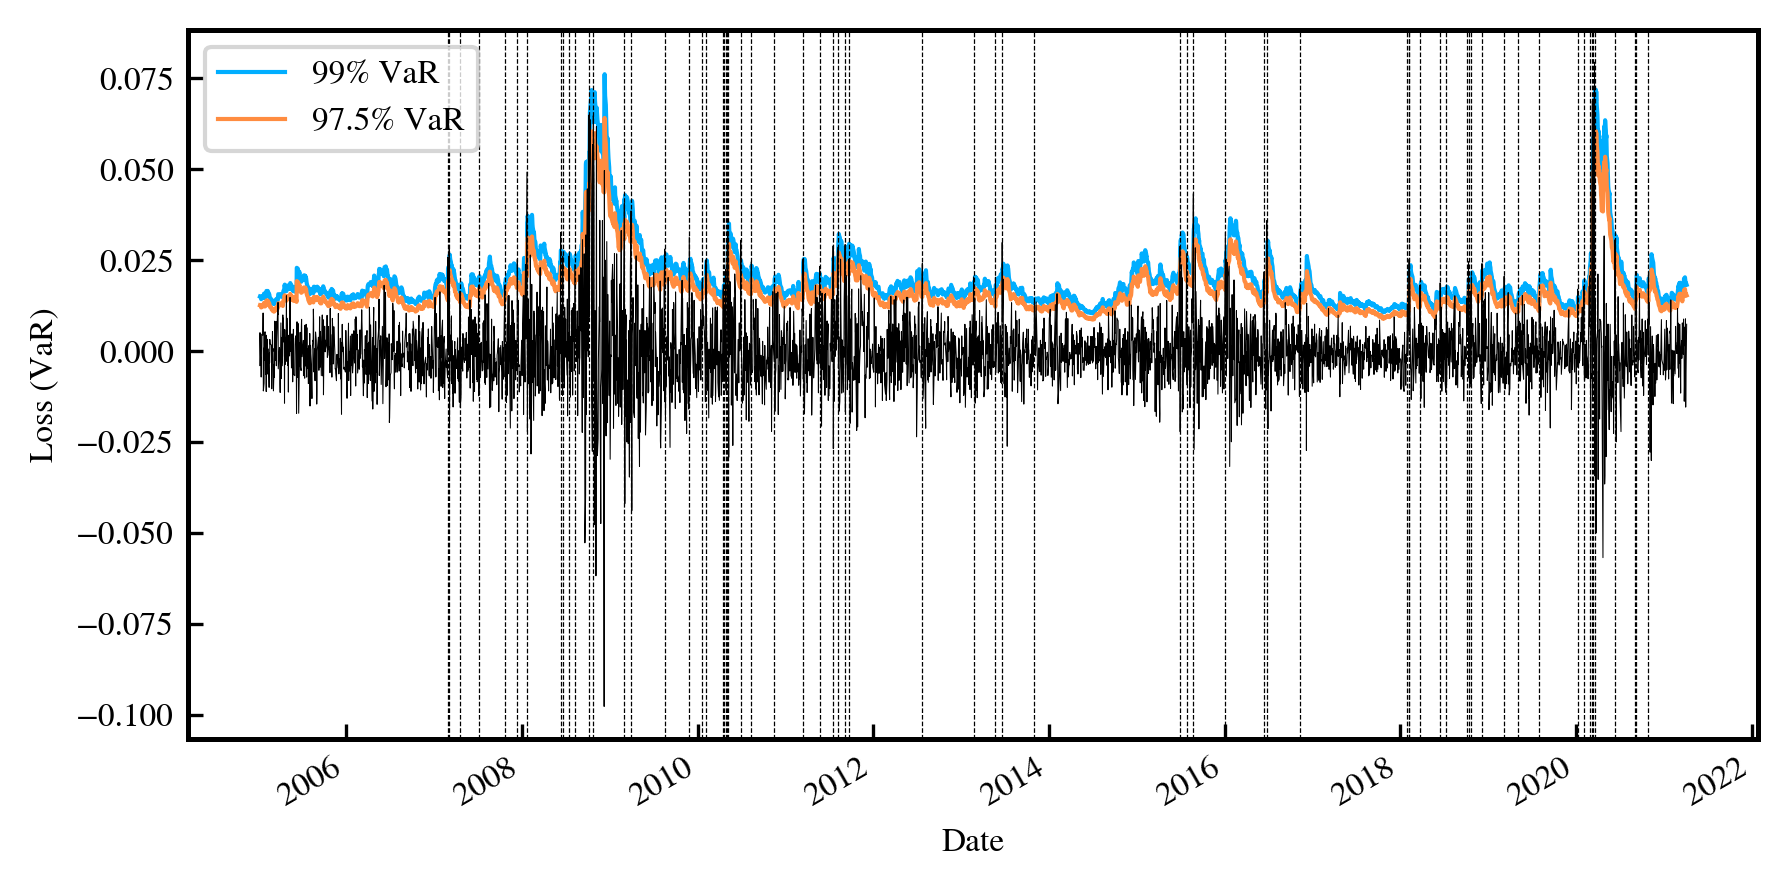

In [249]:
plt.figure(figsize=(6,3))
ccc.VaR01.plot(lw=1, label='99% VaR')
ccc.VaR025.plot(lw=1,label='97.5% VaR')
plt.plot(df.index, -1*portfolio_returns,lw=0.25,color='black')
ccc['portfolioloss'] = -1*portfolio_returns
plt.xlabel('Date')
plt.ylabel('Loss (VaR)')
plt.tight_layout()
for i in ccc.index[(ccc.portfolioloss>ccc.VaR01)]:
    plt.axvline(i,lw=0.3,color='black',ls='--')
plt.legend(frameon=1)
plt.savefig('CCC_VAR.pdf')


In [256]:
(ccc.portfolioloss>ccc.VaR025).sum()

130

In [277]:
#FHS method
def FHS(df, stocks, weights, timeframe=2*252):
    predictions = pd.DataFrame({'VaR01' :np.zeros(len(df))*np.nan,
                                'VaR025':np.zeros(len(df))*np.nan,
                                'ES01'  :np.zeros(len(df))*np.nan,
                                'Date'  :df.index}).set_index('Date')

    ewma_lambda = 0.94
    for time_iter in range(0,len(df)-timeframe):
        # Get data
        
        subreturns = df.iloc[time_iter:time_iter+timeframe]
        residuals    = pd.DataFrame(index=subreturns.index)
        sigma_preds = {}
        for i,asset in enumerate(stocks):
            ret = subreturns[asset].dropna()
            dates = ret.index
            ret = ret.values.flatten()
            # Estimate EWMA model
            EWMA_var = np.zeros(len(ret))
            EWMA_var[:50] = np.var(ret[:50])
            for j in range(50,len(ret)):
                EWMA_var[j] = ewma_lambda * EWMA_var[j-1] + (1-ewma_lambda)*ret[j-1]**2
            EWMA_vol = np.sqrt(EWMA_var)
            # Predict volatility one day ahead
            sigma_pred = np.sqrt(ewma_lambda*EWMA_var[-1] + (1-ewma_lambda)*ret[-1]**2)
            sigma_preds[asset] = sigma_pred
            # Estimate empirical distribution of zt
            zt = (ret-ret.mean()) / EWMA_vol
            # Save residuals
            residuals.loc[dates,asset] = zt
        # Simulate returns for day t+1
        simulated_returns = residuals* sigma_preds
        # Get portfolio returns
        portfolio = np.dot(weights,simulated_returns.T)

        VaR01  = -1*np.percentile(portfolio,1)
        VaR025 = -1*np.percentile(portfolio,2.5)
        ES01   = -1*np.mean(portfolio[portfolio<-1*VaR01])

        # Prediction data
        pred_date = df.iloc[time_iter:time_iter+timeframe+1].index[-1]
        predictions.loc[pred_date] = [VaR01,VaR025,ES01]
    return predictions
fhs = FHS(df,stocks,weights)

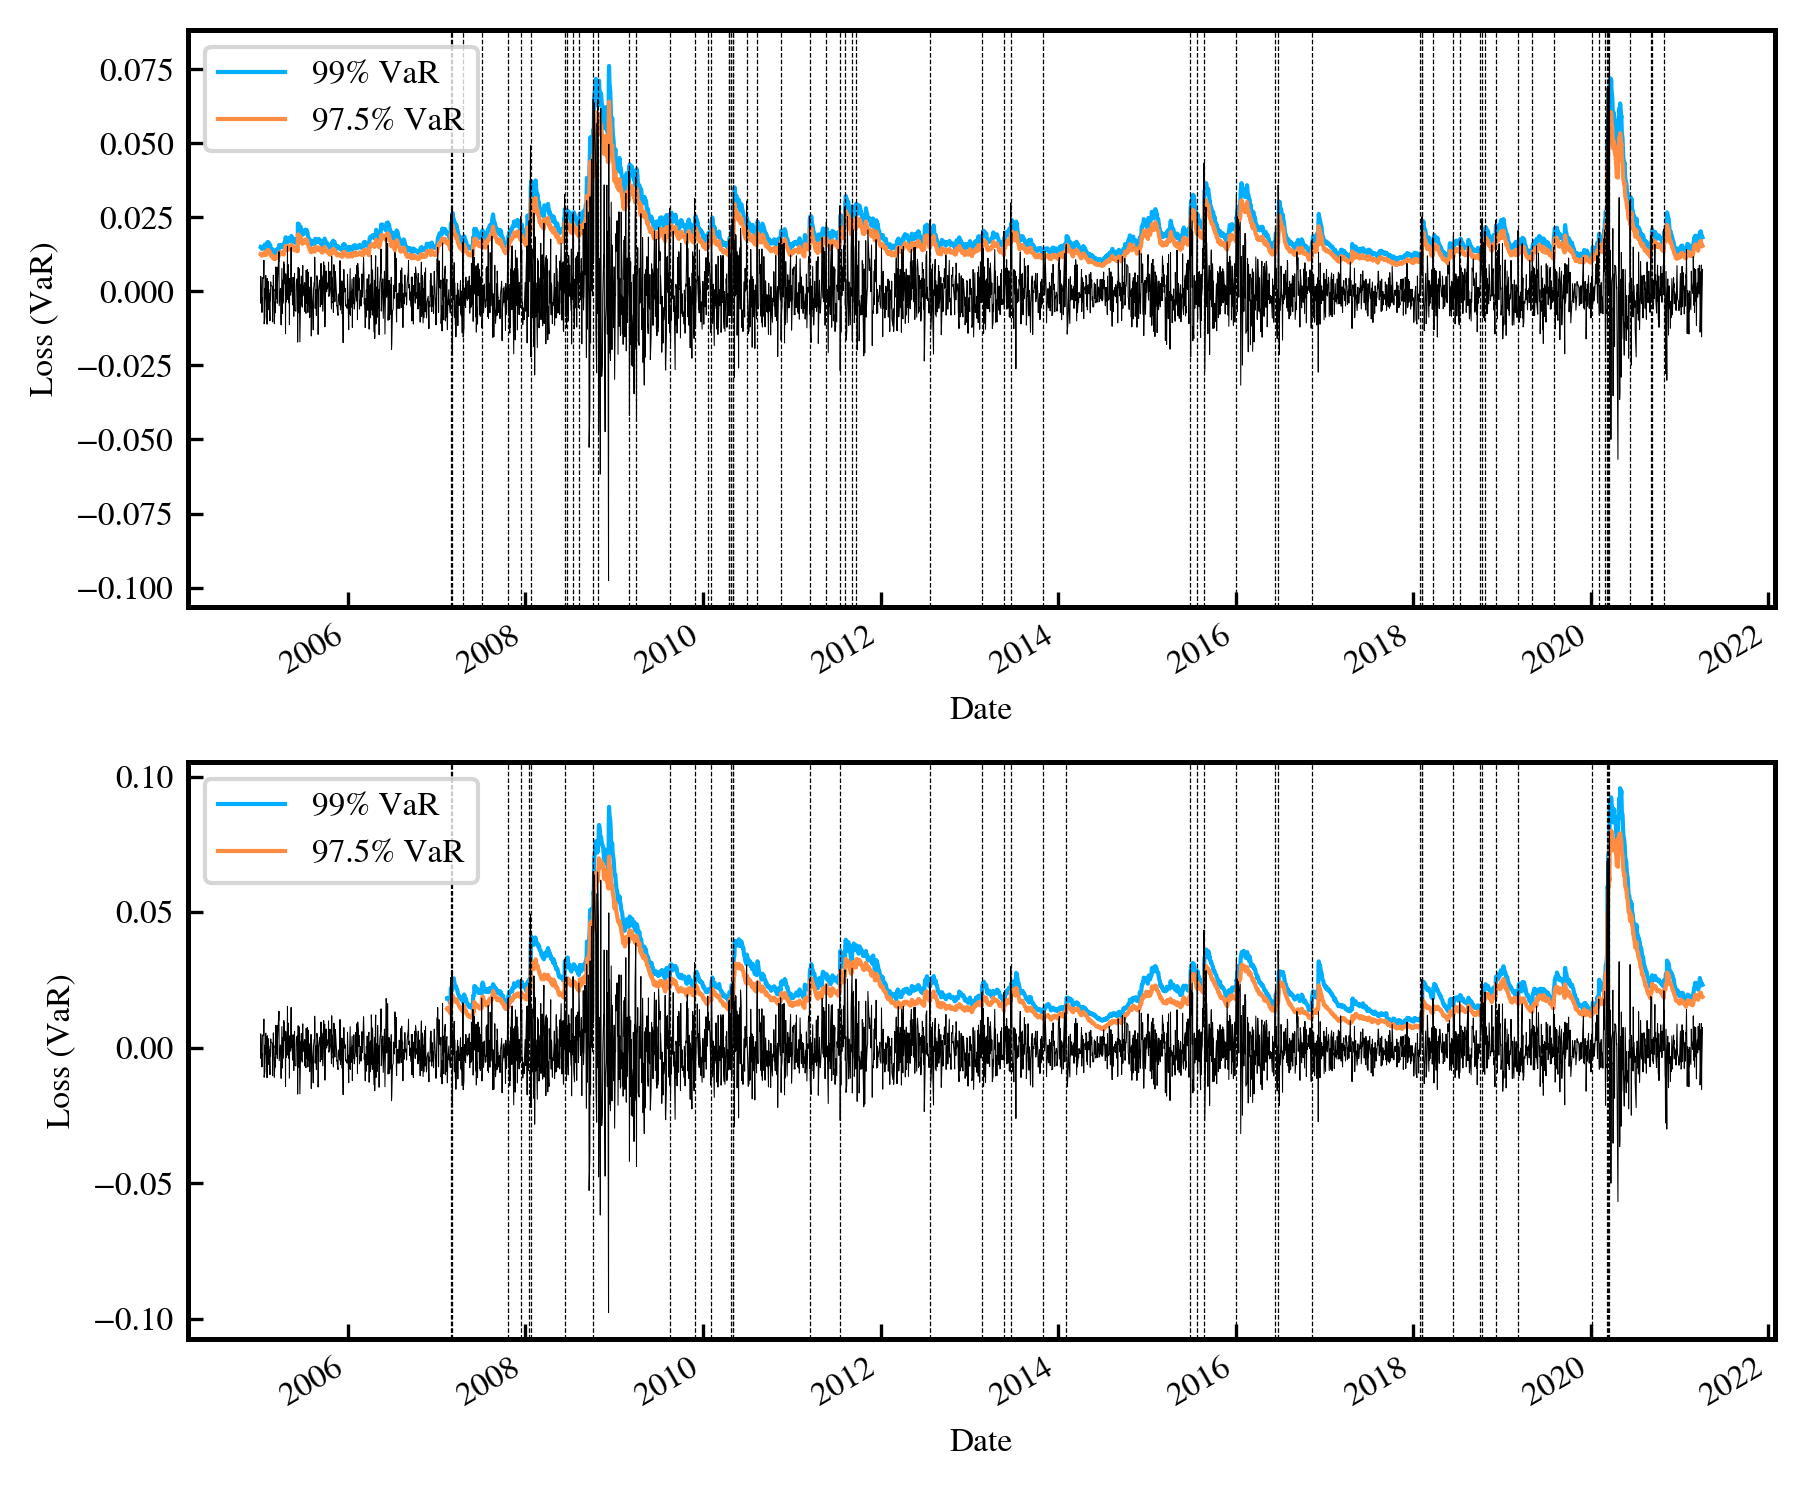

In [287]:
fig, axes = plt.subplots(nrows=2,figsize=(6,5))

ccc.VaR01.plot(lw=1, label='99% VaR', ax=axes[0])
ccc.VaR025.plot(lw=1,label='97.5% VaR', ax=axes[0])
axes[0].plot(df.index, -1*portfolio_returns,lw=0.25,color='black')
ccc['portfolioloss'] = -1*portfolio_returns
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Loss (VaR)')
plt.tight_layout()
for i in ccc.index[(ccc.portfolioloss>ccc.VaR01)]:
    axes[0].axvline(i,lw=0.3,color='black',ls='--')
axes[0].legend(frameon=1)


fhs.VaR01.plot(lw=1, label='99% VaR', ax=axes[1])
fhs.VaR025.plot(lw=1,label='97.5% VaR', ax=axes[1])
axes[1].plot(df.index, -1*portfolio_returns,lw=0.25,color='black')
fhs['portfolioloss'] = -1*portfolio_returns
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Loss (VaR)')
plt.tight_layout()
for i in fhs.index[(fhs.portfolioloss>fhs.VaR01)]:
    axes[1].axvline(i,lw=0.3,color='black',ls='--')
axes[1].legend(frameon=1)
plt.savefig('FHS_CCC_VAR.pdf')


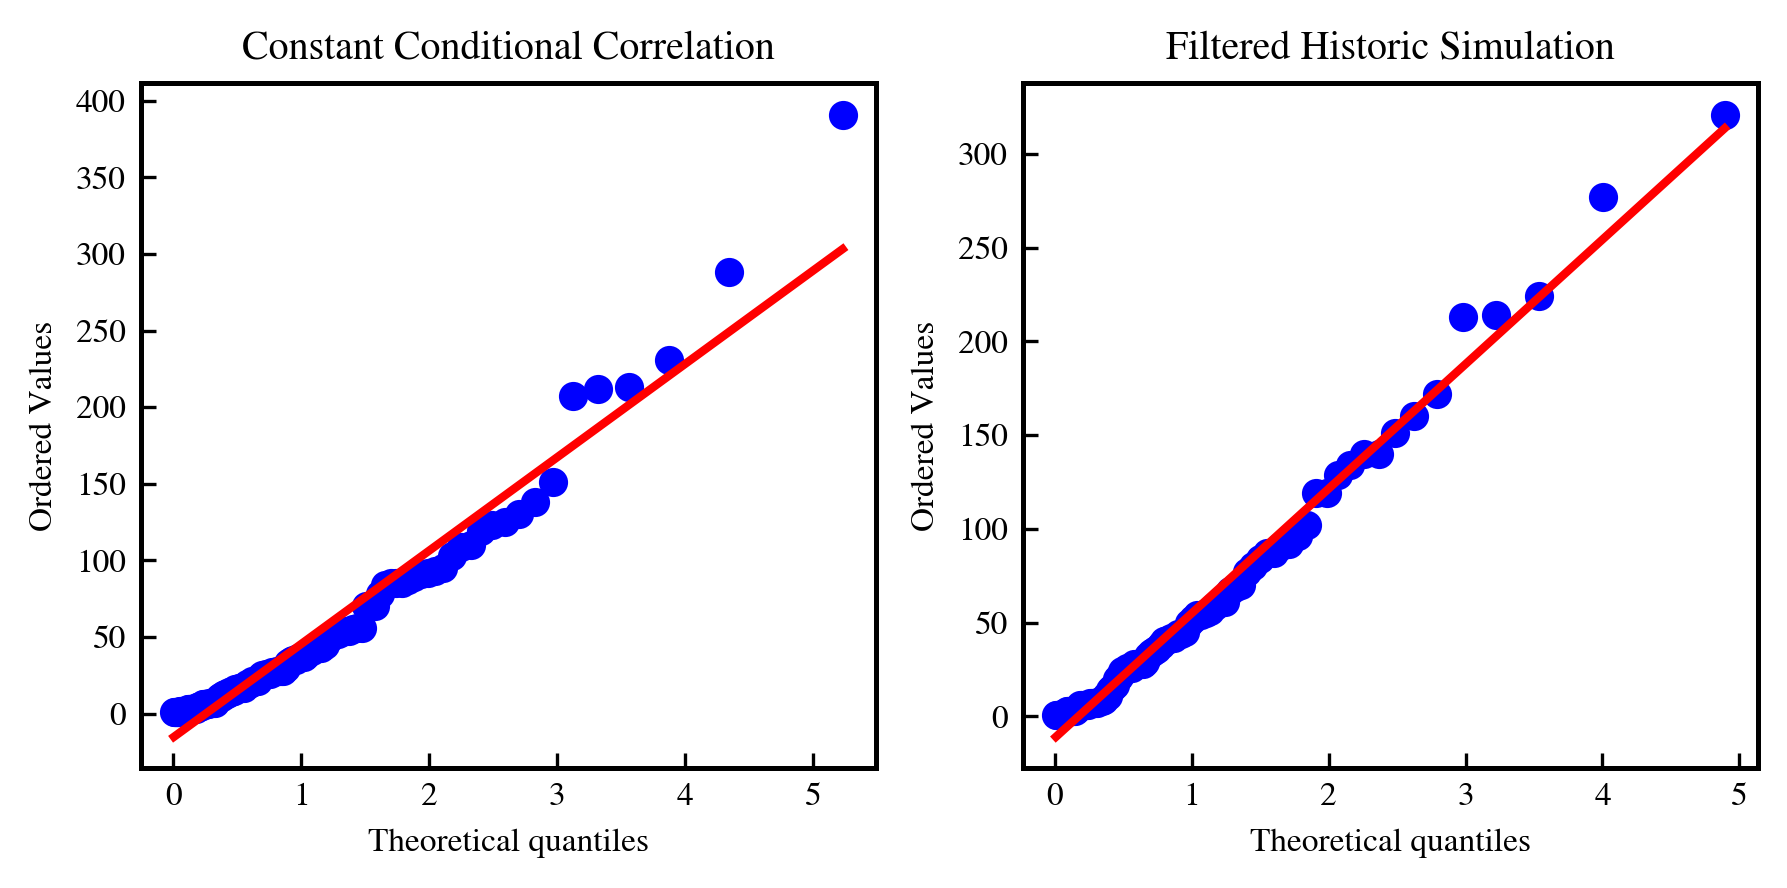

In [282]:
# QQ plots

# QQ plots

exceeding025 = ccc.portfolioloss>ccc.VaR025
# Get index (times) where there is a violation
exceeding025 = exceeding025.index[exceeding025]
# Get time deltas and save in dictionary
timedeltas = np.diff(exceeding025)
from scipy import stats


fig, axes = plt.subplots(ncols=2, figsize=(6,3))
x = (timedeltas/1e9/3600/24).astype(float)
res = stats.probplot(x,plot=axes[0],dist=stats.expon, fit=True)
#ax.scatter(res[0][0], res[0][1],s=1,label=model)
#axes[iter_].set_title(model)
axes[0].set_title('Constant Conditional Correlation')


exceeding025 = fhs.portfolioloss>fhs.VaR025
# Get index (times) where there is a violation
exceeding025 = exceeding025.index[exceeding025]
# Get time deltas and save in dictionary
timedeltas = np.diff(exceeding025)

x = (timedeltas/1e9/3600/24).astype(float)
res = stats.probplot(x,plot=axes[1],dist=stats.expon, fit=True)
#ax.scatter(res[0][0], res[0][1],s=1,label=model)
#axes[iter_].set_title(model)
axes[1].set_title('Filtered Historic Simulation')
plt.tight_layout()
plt.savefig('exponential_QQplots.pdf', bbox_inches='tight')

In [292]:
fhs=fhs.dropna()
(fhs.portfolioloss>fhs.VaR025).mean()

0.026541095890410957